<a href="https://colab.research.google.com/github/todnewman/projects/blob/master/ncaa_wavelet_kpdata_2022_DNN_stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCAA March Madness Bracket Predictor - Kaggle Style

This challenge has two stages.  This code represents the first stage - using historical data to predict tournament games from the last 3 years. 


## Evaluation:

Submissions are scored using negative log loss (cross-entropy):


 \begin{aligned}Negative Log Loss\ =\ -{\frac {1}{n}}\sum _{i=1}^{n}\ {\bigg [}y_{i}\log {\hat {y}}_{i}+(1-y_{i})\log(1-{\hat {y}}_{i}){\bigg ]}\,,\end{aligned}

where:

* n is the number of games played
* $\hat{y}_{i}$ is the predicted probability of team 1 beating team 2
* $y_{i}$ is 1 if team 1 wins, 0 if team 2 wins
* $log()$ is the natural (base e) logarithm

The use of the logarithm means there will be extreme punishment for being both confident and wrong. In the worst possible case, a prediction that something is true when it is actually false will add an infinite amount to your error score. In order to prevent this, predictions are bounded away from the extremes by a small value.

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import scipy.stats
import random

from keras.utils import np_utils
from collections import defaultdict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
pd.options.display.max_columns = 2000
global stage2

## Change directory to where the downloaded Kaggle Data resides

### Example on pulling data from Google Drive
This might be smart to do because then you can save your models and files here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/data/sports

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/data/sports


## Import Kaggle Data into Pandas Dataframes

Ken Pomeroy data comes from https://colab.research.google.com/drive/1iwj6tBUEKdcoY2AbkiLSdwJdwqUK3WMZ

Data is being pulled from Tod's GitHub for convenience of sharing...

In [ ]:
# First, point to the new GitHub Folder

!wget -O /content/MTeams.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MTeams.csv'
!wget -O /content/MSeasons.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MSeasons.csv'
!wget -O /content/MNCAATourneySeeds.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MNCAATourneySeeds.csv'
!wget -O /content/MRegularSeasonDetailedResults.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MRegularSeasonDetailedResults.csv'
!wget -O /content/MNCAATourneyDetailedResults.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MNCAATourneyDetailedResults.csv'
!wget -O /content/sub_results.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/sub_results.csv'
!wget -O /content/MTeamConferences.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MTeamConferences.csv'
!wget -O /content/2022_test_data.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/2022_test_data.csv'
!wget -O /content/MSampleSubmissionStage2_2022.csv 'https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MSampleSubmissionStage2.csv'
!cp sub_results_2016.csv /content/sub_results.csv



--2022-04-06 06:38:47--  https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MTeams.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9814 (9.6K) [text/plain]
Saving to: ‘/content/MTeams.csv’

/content/MTeams.csv 100%[===================>]   9.58K  --.-KB/s    in 0s      

2022-04-06 06:38:47 (77.8 MB/s) - ‘/content/MTeams.csv’ saved [9814/9814]

--2022-04-06 06:38:47--  https://raw.githubusercontent.com/todnewman/data/master/2022NCAABB/MSeasons.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042 (2.0K) [text

In [ ]:
data_dir = '/content/'
stage2 = True # True means the brackets have been built and we have a stage 2 submission file.
yr_limit = 2022 # For stage2 this is used to separate this year's results from our training set.  Should be the current year.

team = pd.read_csv(data_dir + 'MTeams.csv')
season = pd.read_csv(data_dir + 'MSeasons.csv')
season['DayZero'] = pd.to_datetime(season['DayZero'])
seeds = pd.read_csv(data_dir + 'MNCAATourneySeeds.csv')
season_results = pd.read_csv(data_dir + 'MRegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(data_dir + 'MNCAATourneyDetailedResults.csv')
#massey_ord = pd.read_csv(data_dir + 'MMasseyOrdinals.csv')

# actual results for 2015-2018 test data.  Used to calculate log-loss for evaluation.
submission_results = pd.read_csv(data_dir + 'sub_results.csv') 
conferences = pd.read_csv(data_dir + 'MTeamConferences.csv')

# import kenpom data.  Get kenpom script at https://colab.research.google.com/drive/1iwj6tBUEKdcoY2AbkiLSdwJdwqUK3WMZ
# requires a $20 annual subscription
kp_data = pd.read_csv(data_dir + '2022_test_data.csv')
#kp_data = pd.read_csv('2020_test_data.csv')

# Remove references to ghost index columns
try:
    kp_data.drop(columns = ['Unnamed: 0'], inplace=True)
except:
    print('continuing')
    
print(kp_data.columns)
kp_data['TeamID'] = kp_data['TeamID'].fillna(0).astype(int)
pd.options.display.max_columns = 2000
display(kp_data.head())

Index(['Season', 'TeamName', 'eFGPct_d', 'TOPct_d', 'ORPct_d', 'FTRate_d',
       'eFGPct_o', 'TOPct_o', 'ORPct_o', 'FTRate_o', 'FG2Pct', 'FG3Pct',
       'FTPct', 'BlockPct', 'OppFG2Pct', 'OppFG3Pct', 'OppFTPct',
       'OppBlockPct', 'FG3Rate', 'OppFG3Rate', 'ARate', 'OppARate', 'StlRate',
       'OppStlRate', 'DFP', 'NSTRate', 'OppNSTRate', 'Size', 'Hgt5', 'Hgt4',
       'Hgt3', 'Hgt2', 'Hgt1', 'HgtEff', 'Exp', 'Bench', 'Pts5', 'Pts4',
       'Pts3', 'Pts2', 'Pts1', 'OR5', 'OR4', 'OR3', 'OR2', 'OR1', 'DR5', 'DR4',
       'DR3', 'DR2', 'DR1', 'Off_1', 'Off_2', 'Off_3', 'Def_1', 'Def_2',
       'Def_3', 'TeamID', 'Kaggle_Name', 'KP_Name'],
      dtype='object')


,Season,TeamName,eFGPct_d,TOPct_d,ORPct_d,FTRate_d,eFGPct_o,TOPct_o,ORPct_o,FTRate_o,FG2Pct,FG3Pct,FTPct,BlockPct,OppFG2Pct,OppFG3Pct,OppFTPct,OppBlockPct,FG3Rate,OppFG3Rate,ARate,OppARate,StlRate,OppStlRate,DFP,NSTRate,OppNSTRate,Size,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,HgtEff,Exp,Bench,Pts5,Pts4,Pts3,Pts2,Pts1,OR5,OR4,OR3,OR2,OR1,DR5,DR4,DR3,DR2,DR1,Off_1,Off_2,Off_3,Def_1,Def_2,Def_3,TeamID,Kaggle_Name,KP_Name
0,2022,Abilene Christian,51.973684,27.884824,30.918367,49.122807,48.372465,17.666162,27.927147,39.274280,48.408710,32.205882,74.864130,5.851620,52.037618,34.585290,72.193878,10.385260,36.286019,40.037594,56.963614,51.599444,0.143321,0.075341,NaN,10.132063,13.552717,74.27,-1.74,-2.09,-2.76,-3.16,-3.68,-1.91,2.43,33.78,20.57,25.95,21.13,19.57,12.76,26.24,31.50,11.14,14.15,16.94,24.81,29.60,16.02,14.29,15.25,23.307953,48.900169,27.791878,25.438202,44.764045,29.797753,1101,Abilene Chr,Abilene Christian
1,2022,Air Force,51.487889,20.278214,29.397875,38.892734,50.869868,21.474248,19.567691,26.791928,51.600985,33.280000,64.935065,9.128631,53.838174,31.185031,75.978648,11.945813,43.493389,33.287197,57.735247,47.234679,0.085897,0.084810,NaN,12.993279,11.688515,76.98,-0.32,-1.80,-0.24,0.84,1.66,-1.06,1.04,30.07,17.04,17.19,18.95,20.18,26.64,30.57,18.45,18.01,22.69,10.27,31.75,22.34,15.89,16.89,13.13,14.602804,48.948598,36.448598,22.297650,54.203655,23.498695,1102,Air Force,Air Force
2,2022,Akron,49.115801,17.511786,26.369545,26.183685,52.493990,17.805279,28.921569,39.302885,52.205128,35.268505,69.418960,8.730159,47.354497,34.894992,70.588235,7.589744,41.406250,35.310896,48.138298,41.168659,0.086091,0.085602,NaN,9.245049,8.902640,76.44,-0.02,0.27,-0.75,-1.98,-0.08,0.12,1.17,26.04,20.87,24.38,15.86,18.74,20.15,20.56,43.50,16.52,7.33,12.10,15.52,36.07,15.15,14.85,18.41,20.626988,46.251704,33.121308,15.835777,52.492669,31.671554,1103,Akron,Akron
3,2022,Alabama,49.778107,17.929457,30.490748,34.763314,51.327220,19.784228,35.275339,32.866795,55.852535,30.901722,72.834068,11.895625,49.270913,33.793103,71.489362,11.152074,47.635135,35.749507,53.128430,46.110485,0.096036,0.106340,NaN,9.150206,8.325863,77.12,0.63,-0.64,0.24,-0.16,0.76,0.00,1.65,29.69,19.08,17.20,18.81,21.48,23.43,33.05,28.00,19.71,13.30,5.93,19.74,20.67,22.51,21.34,15.74,18.909645,46.206634,34.883721,19.976219,50.891795,29.131986,1104,Alabama,Alabama
4,2022,Alabama A&M,46.314908,19.584078,30.974978,28.643216,41.252887,19.584078,28.657487,33.545035,41.461538,27.083333,71.256454,8.767123,45.205479,32.040230,68.421053,6.615385,24.942263,38.860972,43.445122,56.406685,0.100800,0.108480,NaN,8.736035,9.504038,76.62,-0.42,0.17,0.57,-1.43,-0.56,-0.12,1.72,27.30,17.25,29.43,16.78,12.61,23.91,29.04,28.46,17.98,16.82,7.67,21.35,25.00,21.62,16.35,15.66,22.463375,58.491590,19.045035,17.462687,49.253731,33.283582,1105,Alabama A&M,Alabama A&M


## Gather tournament results for training data

Due to the test data (for 2020 competition) coming from 2015-2018 tournament results, we exclude those years from our training set.

Below we can see all features for each historical tournament game.

In [ ]:
display(tourney_results.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


## Gather key features for the start of our training_set DataFrame

This is our training_data starting point.  

In [ ]:
tourney_results1 = tourney_results
training_set = pd.DataFrame()
training_set['Result'] = np.random.randint(0,2,len(tourney_results1.index))
training_set['Season'] = tourney_results1['Season'].values
training_set['Team1'] = training_set['Result'].values * tourney_results1['WTeamID'].values + (1-training_set['Result'].values) * tourney_results1['LTeamID'].values 
training_set['Team2'] = (1-training_set['Result'].values) * tourney_results1['WTeamID'].values + training_set['Result'].values * tourney_results1['LTeamID'].values 
training_set['Score_Diff'] = tourney_results['WScore'] - tourney_results['LScore']
training_set = training_set.merge(conferences, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
training_set = training_set.merge(conferences, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])


training_set.head()

,Result,Season,Team1,Team2,Score_Diff,TeamID_1,ConfAbbrev_1,TeamID_2,ConfAbbrev_2
0,0,2003,1411,1421,8,1411,swac,1421,big_south
1,0,2003,1436,1112,29,1436,aec,1112,pac_ten
2,0,2003,1272,1113,13,1272,cusa,1113,pac_ten
3,0,2003,1166,1141,6,1166,mvc,1141,mac
4,1,2003,1143,1301,2,1143,pac_ten,1301,acc


## Merge seed values from the seed dataframe into the training set

We'll eventually create the key feature, deltaSeed, which represents the delta in seeding between team1 and team2

In [ ]:
# Calculate Delta Seeds
seeds['Seed'] =  pd.to_numeric(seeds['Seed'].str[1:3], downcast='integer',errors='coerce')
training_set = training_set.merge(seeds, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'])
training_set = training_set.merge(seeds, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'])
training_set['deltaSeed'] = training_set['Seed_x'] - training_set['Seed_y']
training_set.drop(columns = ['Seed_x','TeamID_x','Seed_y','TeamID_y', 'ConfAbbrev_1', 'ConfAbbrev_2'], inplace=True)
training_set.head()

,Result,Season,Team1,Team2,Score_Diff,TeamID_1,TeamID_2,deltaSeed
0,0,2003,1411,1421,8,1411,1421,0
1,0,2003,1436,1112,29,1436,1112,15
2,0,2003,1272,1113,13,1272,1113,-3
3,0,2003,1166,1141,6,1166,1141,-5
4,1,2003,1143,1301,2,1143,1301,-1


## Develop a metric to Adjust for Home court advantage

* Home wins are weighted 0.6 and losses 1.4
* Neutral courts have weight of 1.0 for wins and losses
* Away wins are weighted 1.4 and losses 0.6

These values can be adjusted, but these weights seem to give good results.

Also in this cell we demonstrate how to use Pandas groupby to roll up wins and losses from the season_results dataframe.  We bring this into a dataframe called 'record' to allow us to incorporate this easily into both training_data and test_data.

In [ ]:
season_results['LLoc'] = season_results['WLoc']
season_results.loc[season_results['WLoc'] == 'H','LLoc'] = 'A'
season_results.loc[season_results['WLoc'] == 'A','LLoc'] = 'H'
season_results['WLocWeight'] = season_results['WLoc']
season_results.loc[season_results['WLoc'] == 'H','WLocWeight'] = 0.6
season_results.loc[season_results['WLoc'] == 'N','WLocWeight'] = 1
season_results.loc[season_results['WLoc'] == 'A','WLocWeight'] = 1.4
season_results['LLocWeight'] = season_results['LLoc']
season_results.loc[season_results['LLoc'] == 'H','LLocWeight'] = 1.4
season_results.loc[season_results['LLoc'] == 'N','LLocWeight'] = 1
season_results.loc[season_results['LLoc'] == 'A','LLocWeight'] = 0.6

# 
# Roll up these parameters for each team+year across all their regular season games
#
record = pd.DataFrame({'Adj. wins': season_results.groupby(['Season','WTeamID'])['WLocWeight'].sum(),
                      'Adj. losses': season_results.groupby(['Season','LTeamID'])['LLocWeight'].sum(),
                      'Wins': season_results.groupby(['Season','WTeamID']).size(),
                      'Losses': season_results.groupby(['Season','LTeamID']).size()}).reset_index();

record.rename(index=str,columns={'level_0':'Season',
                                 'level_1':'TeamID'}, inplace=True)

record['games'] = record['Wins']+record['Losses']
record = record.merge(seeds, how = 'left', left_on = ['Season','TeamID'], right_on = ['Season','TeamID'])
record.head()

,Season,TeamID,Adj. wins,Adj. losses,Wins,Losses,games,Seed
0,2003,1102,9.6,13.6,12.0,16.0,28.0,NaN
1,2003,1103,11.0,12.4,13.0,14.0,27.0,NaN
2,2003,1104,12.2,8.6,17.0,11.0,28.0,10.0
3,2003,1105,5.8,17.0,7.0,19.0,26.0,NaN
4,2003,1106,11.8,13.0,13.0,15.0,28.0,NaN


## Function to allow us to build custom features

This is useful because we can apply this to both the training data and the test data.  Much of this feature engineering involves doing Deltas between Team1 and Team2 measures.  

In [ ]:
def build_features(df):
    df['Delta_Adj_Wins'] = df['Adj. wins_1']/df['games_1'] - df['Adj. wins_2']/df['games_2']
    df['XDef4Fac_1'] = df['eFGPct_d_1']*df['TOPct_d_1']*df['ORPct_d_1']*df['FTRate_d_1']
    df['XDef4Fac_2'] = df['eFGPct_d_2']*df['TOPct_d_2']*df['ORPct_d_2']*df['FTRate_d_2']
    df['Delta_Def4Fac'] = df['XDef4Fac_1'] - df['XDef4Fac_2']
    
    df['XOff4Fac_1'] = df['eFGPct_o_1']*df['TOPct_o_1']*df['ORPct_o_1']*df['FTRate_o_1']
    df['XOff4Fac_2'] = df['eFGPct_o_2']*df['TOPct_o_2']*df['ORPct_o_2']*df['FTRate_o_2']
    df['Delta_Off4Fac'] = df['XOff4Fac_1'] - df['XOff4Fac_2']
    
    df['DeltaXDeFG'] = df['eFGPct_d_1'] - df['eFGPct_d_2']
    df['DeltaXDeTO'] = df['TOPct_d_1'] - df['TOPct_d_2']
    df['DeltaXOfFG'] = df['eFGPct_o_1'] - df['eFGPct_o_2']
    df['DeltaXOfTO'] = df['TOPct_o_1'] - df['TOPct_o_2']
    df['DeltaXDeOR'] = df['ORPct_d_1'] - df['ORPct_d_2']
    df['DeltaXDeFT'] = df['FTRate_d_1'] - df['FTRate_d_2']
    df['DeltaXOfOR'] = df['ORPct_o_1'] - df['ORPct_o_2']
    df['DeltaXOfFT'] = df['FTRate_o_1'] - df['FTRate_o_2']
    df['DeltaSize'] = df['Size_1'] - df['Size_2']
    df['DeltaFT'] = df['Exp_1']*df['FTPct_1'] - df['Exp_2']*df['FTPct_2']
    df['DeltaFG2'] = df['FG2Pct_1'] - df['FG2Pct_2']
    df['DeltaFG3'] = df['FG3Pct_1'] - df['FG3Pct_2']
    df['DeltaHgtEff'] = df['HgtEff_1'] - df['HgtEff_2']
    df['DeltaBlock'] = df['BlockPct_1'] - df['BlockPct_2']
    df['DeltaHt4'] = df['Hgt4_1'] - df['Hgt4_2']
    df['DeltaHt5'] = df['Hgt5_1'] - df['Hgt5_2']
    df['DeltaHt3'] = df['Hgt3_1'] - df['Hgt3_2']
    df['DeltaHt2'] = df['Hgt2_1'] - df['Hgt2_2']
    df['DeltaHt1'] = df['Hgt1_1'] - df['Hgt1_2']
    df['DeltaOR5'] = df['OR5_1'] - df['OR5_2']
    df['DeltaDR5'] = df['DR5_1'] - df['DR5_2']
    df['DeltaExp'] = df['Exp_1'] - df['Exp_2']
    df['DeltaAst_to_Steal'] = df['ARate_1']/(df['OppStlRate_1']) - df['ARate_2']/(df['OppStlRate_2'])
    df['Win_Def_Cross'] = df['Delta_Adj_Wins'] * (df['XDef4Fac_1'] - df['XDef4Fac_2'])
    df['Win_Off_Cross'] = df['Delta_Adj_Wins'] * (df['XOff4Fac_1'] - df['XOff4Fac_2'])
    df['Size_Eff_Cross'] = df['DeltaSize'] * df['DeltaFT'] * df['DeltaAst_to_Steal']
    return df

## Merge Adjusted Wins record and KenPom data into training set

Also, this is where we eliminate data from after 2015 from our training set and call build_features to set up our custom features.

In [ ]:
training_set = training_set.merge(record, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
training_set = training_set.merge(record, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
training_set = training_set.merge(kp_data, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
training_set = training_set.merge(kp_data, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])

training_set = build_features(training_set)
training_set = training_set.fillna(0)

filter_ts = training_set['Season'] < yr_limit  #  Change the Year for Stage 1 competitions...
training_set = training_set[filter_ts]
pd.options.display.max_columns = 2000
print(training_set.shape)
display(training_set.tail())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TeamID_1'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


(1181, 173)


,Result,Season,Team1,Team2,Score_Diff,TeamID_1,TeamID_2,deltaSeed,TeamID_1,Adj. wins_1,Adj. losses_1,Wins_1,Losses_1,games_1,Seed_1,TeamID_2,Adj. wins_2,Adj. losses_2,Wins_2,Losses_2,games_2,Seed_2,TeamName_1,eFGPct_d_1,TOPct_d_1,ORPct_d_1,FTRate_d_1,eFGPct_o_1,TOPct_o_1,ORPct_o_1,FTRate_o_1,FG2Pct_1,FG3Pct_1,FTPct_1,BlockPct_1,OppFG2Pct_1,OppFG3Pct_1,OppFTPct_1,OppBlockPct_1,FG3Rate_1,OppFG3Rate_1,ARate_1,OppARate_1,StlRate_1,OppStlRate_1,DFP_1,NSTRate_1,OppNSTRate_1,Size_1,Hgt5_1,Hgt4_1,Hgt3_1,Hgt2_1,Hgt1_1,HgtEff_1,Exp_1,Bench_1,Pts5_1,Pts4_1,Pts3_1,Pts2_1,Pts1_1,OR5_1,OR4_1,OR3_1,OR2_1,OR1_1,DR5_1,DR4_1,DR3_1,DR2_1,DR1_1,Off_1_1,Off_2_1,Off_3_1,Def_1_1,Def_2_1,Def_3_1,TeamID_1,Kaggle_Name_1,KP_Name_1,TeamName_2,eFGPct_d_2,TOPct_d_2,ORPct_d_2,FTRate_d_2,eFGPct_o_2,TOPct_o_2,ORPct_o_2,FTRate_o_2,FG2Pct_2,FG3Pct_2,FTPct_2,BlockPct_2,OppFG2Pct_2,OppFG3Pct_2,OppFTPct_2,OppBlockPct_2,FG3Rate_2,OppFG3Rate_2,ARate_2,OppARate_2,StlRate_2,OppStlRate_2,DFP_2,NSTRate_2,OppNSTRate_2,Size_2,Hgt5_2,Hgt4_2,Hgt3_2,Hgt2_2,Hgt1_2,HgtEff_2,Exp_2,Bench_2,Pts5_2,Pts4_2,Pts3_2,Pts2_2,Pts1_2,OR5_2,OR4_2,OR3_2,OR2_2,OR1_2,DR5_2,DR4_2,DR3_2,DR2_2,DR1_2,Off_1_2,Off_2_2,Off_3_2,Def_1_2,Def_2_2,Def_3_2,TeamID_2,Kaggle_Name_2,KP_Name_2,Delta_Adj_Wins,XDef4Fac_1,XDef4Fac_2,Delta_Def4Fac,XOff4Fac_1,XOff4Fac_2,Delta_Off4Fac,DeltaXDeFG,DeltaXDeTO,DeltaXOfFG,DeltaXOfTO,DeltaXDeOR,DeltaXDeFT,DeltaXOfOR,DeltaXOfFT,DeltaSize,DeltaFT,DeltaFG2,DeltaFG3,DeltaHgtEff,DeltaBlock,DeltaHt4,DeltaHt5,DeltaHt3,DeltaHt2,DeltaHt1,DeltaOR5,DeltaDR5,DeltaExp,DeltaAst_to_Steal,Win_Def_Cross,Win_Off_Cross,Size_Eff_Cross
1176,1,2021,1211,1425,19,1211,1425,-5,1211,24.0,0.0,26.0,0.0,0.0,1.0,1425,19.6,6.6,22.0,7.0,29.0,6.0,Gonzaga,47.685656,19.311630,23.781009,25.686673,61.017812,16.127934,30.070636,35.725191,63.899467,36.809816,73.076923,6.907137,46.968534,32.730015,70.297030,6.778370,33.180662,33.723296,55.607044,45.476478,0.106402,0.081687,0.0,7.959240,8.671383,78.11,0.83,0.47,0.69,1.77,2.21,0.65,1.54,24.27,25.77,21.49,16.72,17.33,18.63,39.47,19.89,6.54,22.61,11.41,23.99,18.56,13.28,24.63,19.49,17.622810,57.643422,24.733768,15.919283,54.887892,29.192825,1211.0,Gonzaga,Gonzaga,USC,44.850000,16.924156,28.273092,24.100000,52.738654,18.028866,34.919210,36.254564,52.154195,36.026936,64.892086,12.942989,42.064715,33.333333,73.443983,6.878307,30.985915,35.100000,50.663717,53.846154,0.069376,0.081307,0.0,9.898201,9.986578,79.37,2.61,2.68,3.43,2.66,0.91,2.65,1.70,28.68,25.02,18.92,16.79,19.72,19.52,33.16,33.90,11.50,15.70,5.71,27.49,24.65,22.29,13.93,11.60,18.236959,55.802669,25.960372,16.480447,50.837989,32.681564,1425.0,USC,USC,0.000000,5.625289e+05,5.172016e+05,45327.360134,1.057189e+06,1.203717e+06,-146528.682279,2.835656,2.387474,8.279158,-1.900932,-4.492083,1.586673,-4.848574,-0.529374,-1.26,2.221915,11.745272,0.782880,-2.00,-6.035852,-2.21,-1.78,-2.74,-0.89,1.30,6.31,-3.50,-0.16,57.614612,0.000000,0.000000,-161.298595
1177,0,2021,1276,1417,2,1276,1417,-10,1276,17.2,3.6,20.0,4.0,24.0,1.0,1417,14.6,7.0,17.0,9.0,26.0,11.0,Michigan,44.405183,14.779556,24.691358,24.322733,54.693367,16.567829,29.629630,30.350438,53.453169,38.077634,76.907216,10.112360,42.610199,32.162662,76.029056,7.379376,33.854819,31.861013,57.457847,41.979010,0.063116,0.073109,0.0,9.256946,8.468002,77.89,2.83,1.88,1.94,-0.44,-1.32,2.36,2.12,25.00,26.78,20.29,20.11,17.70,15.06,42.46,18.69,19.94,12.01,6.84,27.10,23.71,23.52,14.40,11.21,17.569477,53.226566,29.109750,17.233809,54.116356,28.649835,1276.0,Michigan,Michigan,UCLA,50.414136,17.495823,25.070159,28.161237,52.021563,15.685911,30.451128,31.590296,50.275808,37.201365,71.501706,7.890071,50.354610,33.674963,71.372549,7.328605,31.590296,37.713970,51.051402,49.624060,0.073325,0.072861,0.0,8.399851,10.163356,77.29,0.12,-0.72,1.13,2.21,-0.84,-0.30,1.38,27.39,21.80,24.23,19.49,17.65,16.77,33.99,12.04,23.84,25.96,4.07,30.36,17.31,21.36,20.79,10.10,17.837378,54.320988,27.841635,16.621005,51.872146,31.506849,1417.0,UCLA,UCLA,0.155128,3.941417e+05,6.227239e+05,-228582.18772

## Start building Test Data

Here we start with the Kaggle sample_submission.  This allows us to grab the teams and seasons for tournament games between 2015 and 2018.

We start with grabbing the submission ID key and then separating out Season, Team1, and Team2.  We keep the key around too because we'll need it eventually for submission.

Next, we merge in the Adjusted Win record, conference data, and finally Ken Pomeroy data.  Then we call build_features to build custom features and at that point we have the same critical features as we do in the training set.

In [ ]:


if stage2:
    sample_submission = pd.read_csv(data_dir + 'MSampleSubmissionStage2_2022.csv') # Update for Stage 1 submissions
else:
    sample_submission = pd.read_csv('MSampleSubmissionStage1.csv')
sample_submission['Season'] = sample_submission['ID'].apply(lambda x: x.split('_')[0]).astype(int)
#df = pd.DataFrame()
#df2 = pd.DataFrame()
test = sample_submission.copy()


test['Team1'] = test['ID'].apply(lambda x: x.split('_')[1]).astype(int)
test['Team2'] = test['ID'].apply(lambda x: x.split('_')[2]).astype(int)

test_set = test.merge(record, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
test_set = test_set.merge(record, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])

test_set = test_set.merge(conferences, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
test_set = test_set.merge(conferences, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])

test_set = test_set.merge(kp_data, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
test_set = test_set.merge(kp_data, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
test_set['deltaSeed'] = test_set['Seed_1'] - test_set['Seed_2']

test_set = build_features(test_set)
test_set = test_set.fillna(0)
#print(test_set.keys()[0:30])
#print(test_set.shape)

display(test_set.head())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TeamID_1'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


,ID,Pred,Season,Team1,Team2,TeamID_1,Adj. wins_1,Adj. losses_1,Wins_1,Losses_1,games_1,Seed_1,TeamID_2,Adj. wins_2,Adj. losses_2,Wins_2,Losses_2,games_2,Seed_2,TeamID_1,ConfAbbrev_1,TeamID_2,ConfAbbrev_2,TeamName_1,eFGPct_d_1,TOPct_d_1,ORPct_d_1,FTRate_d_1,eFGPct_o_1,TOPct_o_1,ORPct_o_1,FTRate_o_1,FG2Pct_1,FG3Pct_1,FTPct_1,BlockPct_1,OppFG2Pct_1,OppFG3Pct_1,OppFTPct_1,OppBlockPct_1,FG3Rate_1,OppFG3Rate_1,ARate_1,OppARate_1,StlRate_1,OppStlRate_1,DFP_1,NSTRate_1,OppNSTRate_1,Size_1,Hgt5_1,Hgt4_1,Hgt3_1,Hgt2_1,Hgt1_1,HgtEff_1,Exp_1,Bench_1,Pts5_1,Pts4_1,Pts3_1,Pts2_1,Pts1_1,OR5_1,OR4_1,OR3_1,OR2_1,OR1_1,DR5_1,DR4_1,DR3_1,DR2_1,DR1_1,Off_1_1,Off_2_1,Off_3_1,Def_1_1,Def_2_1,Def_3_1,TeamID_1,Kaggle_Name_1,KP_Name_1,TeamName_2,eFGPct_d_2,TOPct_d_2,ORPct_d_2,FTRate_d_2,eFGPct_o_2,TOPct_o_2,ORPct_o_2,FTRate_o_2,FG2Pct_2,FG3Pct_2,FTPct_2,BlockPct_2,OppFG2Pct_2,OppFG3Pct_2,OppFTPct_2,OppBlockPct_2,FG3Rate_2,OppFG3Rate_2,ARate_2,OppARate_2,StlRate_2,OppStlRate_2,DFP_2,NSTRate_2,OppNSTRate_2,Size_2,Hgt5_2,Hgt4_2,Hgt3_2,Hgt2_2,Hgt1_2,HgtEff_2,Exp_2,Bench_2,Pts5_2,Pts4_2,Pts3_2,Pts2_2,Pts1_2,OR5_2,OR4_2,OR3_2,OR2_2,OR1_2,DR5_2,DR4_2,DR3_2,DR2_2,DR1_2,Off_1_2,Off_2_2,Off_3_2,Def_1_2,Def_2_2,Def_3_2,TeamID_2,Kaggle_Name_2,KP_Name_2,deltaSeed,Delta_Adj_Wins,XDef4Fac_1,XDef4Fac_2,Delta_Def4Fac,XOff4Fac_1,XOff4Fac_2,Delta_Off4Fac,DeltaXDeFG,DeltaXDeTO,DeltaXOfFG,DeltaXOfTO,DeltaXDeOR,DeltaXDeFT,DeltaXOfOR,DeltaXOfFT,DeltaSize,DeltaFT,DeltaFG2,DeltaFG3,DeltaHgtEff,DeltaBlock,DeltaHt4,DeltaHt5,DeltaHt3,DeltaHt2,DeltaHt1,DeltaOR5,DeltaDR5,DeltaExp,DeltaAst_to_Steal,Win_Def_Cross,Win_Off_Cross,Size_Eff_Cross
0,2022_1103_1104,0.5,2022,1103,1104,1103,21.2,8.6,22.0,9.0,31.0,13.0,1104,15.4,11.8,19.0,13.0,32.0,6.0,1103,mac,1104,sec,Akron,49.115801,17.511786,26.369545,26.183685,52.49399,17.805279,28.921569,39.302885,52.205128,35.268505,69.41896,8.730159,47.354497,34.894992,70.588235,7.589744,41.40625,35.310896,48.138298,41.168659,0.086091,0.085602,0.0,9.245049,8.90264,76.44,-0.02,0.27,-0.75,-1.98,-0.08,0.12,1.17,26.04,20.87,24.38,15.86,18.74,20.15,20.56,43.5,16.52,7.33,12.1,15.52,36.07,15.15,14.85,18.41,20.626988,46.251704,33.121308,15.835777,52.492669,31.671554,1103,Akron,Akron,Alabama,49.778107,17.929457,30.490748,34.763314,51.327220,19.784228,35.275339,32.866795,55.852535,30.901722,72.834068,11.895625,49.270913,33.793103,71.489362,11.152074,47.635135,35.749507,53.128430,46.110485,0.096036,0.106340,0.0,9.150206,8.325863,77.12,0.63,-0.64,0.24,-0.16,0.76,0.00,1.65,29.69,19.08,17.20,18.81,21.48,23.43,33.05,28.00,19.71,13.30,5.93,19.74,20.67,22.51,21.34,15.74,18.909645,46.206634,34.883721,19.976219,50.891795,29.131986,1104,Alabama,Alabama,7.0,0.202621,593861.366214,946007.879851,-352146.513636,1.062441e+06,1.177322e+06,-114881.854547,-0.662305,-0.417671,1.166770,-1.978949,-4.121203,-8.579628,-6.353771,6.436089,-0.68,-38.956028,-3.647406,4.366783,0.12,-3.165467,0.91,-0.65,-0.99,-1.82,-0.84,-12.49,-4.22,-0.48,62.740136,-71352.267380,-23277.472544,1661.992427
1,2022_1103_1112,0.5,2022,1103,1112,1103,21.2,8.6,22.0,9.0,31.0,13.0,1112,27.8,1.8,31.0,3.0,34.0,1.0,1103,mac,1112,pac_twelve,Akron,49.115801,17.511786,26.369545,26.183685,52.49399,17.805279,28.921569,39.302885,52.205128,35.268505,69.41896,8.730159,47.354497,34.894992,70.588235,7.589744,41.40625,35.310896,48.138298,41.168659,0.086091,0.085602,0.0,9.245049,8.90264,76.44,-0.02,0.27,-0.75,-1.98,-0.08,0.12,1.17,26.04,20.87,24.38,15.86,18.74,20.15,20.56,43.5,16.52,7.33,12.1,15.52,36.07,15.15,14.85,18.41,20.626988,46.251704,33.121308,15.835777,52.492669,31.671554,1103,Akron,Akron,Arizona,44.354167,17.420992,28.580687,24.041667,55.553107,18.343714,34.680679,34.949317,57.083906,35.214724,73.896595,13.401404,41.799617,32.773109,67.417678,7.359010,35.918907,34.708333,64.995524,47.198276,0.091903,0.094856,0.0,8.858131,8.230681,79.44,3.50,2.98,1.48,1.88,2.59,3.24,1.34,29.19,22.63,22.20,20.84,18.62,15.69,38.39,25.95,15.92,13.26,6.44,26.59,23.10,18.74,18.55,12.98,18.860637,53.427744,27.711619,15.448769,52.025417,32.525

## Below we call out the full set of engineered features.

We may not use all these in our model.  Most likely, we'll use our feature_select function to eliminate the features with ultra-low mutual information with the Result feature (the target).

In [ ]:
features_low_risk = ['deltaSeed', 'DeltaSize', 'Delta_Off4Fac', 'Delta_Def4Fac', 'DeltaFG2', 'DeltaFG3', 'DeltaBlock', 'DeltaHt4', 'DeltaHt5',
        'Delta_Adj_Wins', 'DeltaFT', 'DeltaAst_to_Steal', 'Win_Def_Cross', 'DeltaHgtEff', 'DeltaHt3', 'DeltaHt2', 'DeltaHt1',
        'Size_Eff_Cross', 'DeltaXDeFG', 'DeltaXOfFG', 'DeltaXDeTO', 'DeltaXOfTO', 'DeltaOR5', 'DeltaDR5',
        'DeltaXDeOR', 'DeltaXOfOR', 'DeltaXDeFT', 'DeltaXOfFT', 'DeltaExp', 'Result'
           ]

features_risk = [ 'DeltaSize', 'Delta_Off4Fac', 'Delta_Def4Fac', 'DeltaFG2', 'DeltaFG3', 'DeltaBlock', 'DeltaHt4', 'DeltaHt5',
        'Delta_Adj_Wins', 'DeltaFT', 'DeltaAst_to_Steal', 'Win_Def_Cross', 'DeltaHgtEff', 'DeltaHt3', 'DeltaHt2', 'DeltaHt1',
        'Size_Eff_Cross', 'DeltaXDeFG', 'DeltaXOfFG', 'DeltaXDeTO', 'DeltaXOfTO', 'DeltaOR5', 'DeltaDR5',
        'DeltaXDeOR', 'DeltaXOfOR', 'DeltaXDeFT', 'DeltaXOfFT', 'DeltaExp', 'Result'
           ]

features = features_risk

## Utility Functions

* score_submission
* handle_submission
* feature_select
* get_mutual_information
* calculate_entropy
* calculate_statistics
* calculate_crossings
* get_features
* split_data
* build_wv_features

see function docstrings for description


In [ ]:
def score_submission(sub):
    """ 
    Summary line. Calculate a quick log_loss on submission data.
  
    Extended description of function. Since this challenge uses log loss for scoring, this function will take submission data 
    and calculate the expected and predicted values for log loss calculation.  This is called by handle_submission
  
    Parameters: 
    sub (Pandas DataFrame): ID and predictions from the classifier
  
    Returns: 
    df: DataFrame consisting of true and predicted labels 
  
    """
    from sklearn.metrics import log_loss
    
    df = pd.DataFrame()
    pred_list = []
    
    # Look at every row in the 2015-2018 tournament results file (truth)
    for index, row in submission_results.iterrows():
        ID = row['ID']
        filter_id = sub['ID'] == ID
        pred_list.append(sub[filter_id]['pred'])

    true_label = submission_results['Result']
   
    df['true'] = true_label
    df['pred'] = np.array(pred_list)
    #df['pred'] = df['pred'].apply(pd.to_numeric, errors="ignore").applymap(lambda x: isinstance(x, float), na_action='ignore').any()

    #df['pred'] = df['pred'].apply(lambda x: float(x))

    result = log_loss(df['true'], df['pred'])
    
    
    return df, result


def handle_submission(pred, test_set, flag):
    """ 
    Summary line. Prepare Final Submission for Kaggle
  
    Extended description of function. This function takes the ID from our test_set data and our classifier's probability 
    of Team1 win prediction and then evaluates the scores.  It will adjust scores that are unconfident or over-confident
    to hopefully maximize the log-loss function.  This function will save off 'adjusted' and 'not-adjusted' files as 
    defined by the flag.
  
    Parameters: 
    pred (Pandas Series): Predictions from the classifier
    test_set (Pandas DataFrame): test_data to use to gather the ID
    flag: If 'Adjust', then adjust the predictions for confidence
  
    Returns: 
    df: DataFrame of expected and predicted values to use in Sklearn metrics, etc. 
  
    """
    # Note the below is to distinguish whether we're in a Kaggle Stage 1 or Stage 2 of the competition
    stage1 = False

    submission = pd.DataFrame()
    submission['ID'] = test_set['ID']
    submission['pred'] = pred
    
    # Split out Season, Team1, and Team2 from the ID
    submission['Season'] = submission['ID'].apply(lambda x: x.split('_')[0]).astype(int)
    submission['Team1'] = submission['ID'].apply(lambda x: x.split('_')[1]).astype(int)
    submission['Team2'] = submission['ID'].apply(lambda x: x.split('_')[2]).astype(int)
    
    # Merge in seed values to use for Adjustment below
    submission = submission.merge(seeds, how='left', left_on=['Season','Team1'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
    submission = submission.merge(seeds, how='left', left_on=['Season','Team2'], right_on = ['Season','TeamID'], suffixes = ['_1','_2'])
    
    #  Adjust unconfident values giving slightly more weight in these cases to the higher seed.
    #  Also adujst over/under-confident values slightly to minimize risk.
    if flag == 'Adjust':
        for index, row in submission.iterrows():
            if row['pred'] > 0.45 and row['pred'] <= .55:
                if row['Seed_2'] > row['Seed_1']:        # Uncertain prediction and team2 is seeded worse than team1
                    submission.loc[index,'pred'] += 0.1  # Increase confidence for team1              
                else:                                    # Uncertain prediction and team1 is seeded worse than team2
                    submission.loc[index,'pred'] -= 0.1  # Decrease confidence for team1
            elif row['pred'] > 0.93:
                submission.loc[index, 'pred'] -= 0.1
            elif row['pred'] < 0.07:
                submission.loc[index, 'pred'] += 0.1
        filename = 'submission-adjusted.csv'
    else:
        print('no adjustment')
        filename = 'submission-no_adjust.csv'
    submission.drop(columns = ['Seed_1','Team1','Seed_2','Team2', 'Season', 'TeamID_1', 'TeamID_2'], inplace=True)
    if stage1:
        submission.to_csv(filename, index=False)
        df, result = score_submission(submission)  # broke right now
        return df, result
    else:
        submission.to_csv(filename, index=False)
        return 0


def feature_select(target, df_hist,  mi_flag, ratio=0.4): 
    """ 
    Summary line. Determine optimal set of features for a particular classification/regression
  
    Extended description of function. This function determines through correlation the most 
    important features based on a predetermined ratio.  If the mutual_information flag is set to True
    it will use mutual information instead of correlation to determine importance.
  
    Parameters: 
    target (string): The header for the Target feature
    df_hist (Pandas DataFrame): Historical Data to use for evaluating correlation/mutual information
    mi_flag (boolean): If True, then use mutual information to define the features to use
    ratio: This describes the ratio of the upper and lower bound that we will use.  Effectively, 
    a ratio of 0.5 should bring in all features, whereas a ratio of 0.1 will only grab the top 20%.
  
    Returns: 
    total_range: The list of most important features
  
    """     
    print(df_hist.columns)        
    # Open a dataframe just to create the correlation matrix                             
    df_new = pd.DataFrame()    
    df_new = df_hist.corr().sort_values(target, ascending = False) 

    size = len(df_new) # number of features in the correlation   
    
    upper_limit = int(size*ratio)     # Positive Correlations
    lower_limit = int(size*(1-ratio)) # Negative Correlations
    
    upper_range = df_new[target].index[1:upper_limit].tolist()
    lower_range = df_new[target].index[lower_limit:size].tolist()
    

    # Below allows us to switch between mutual information-based and correlation-based feature selectors

    if mi_flag:
        total_range = get_mutual_information(df_hist, target, upper_limit)
    else:
        total_range = (upper_range + lower_range)

    print(('selected features: ', total_range))

    return (total_range)


def get_mutual_information(df, target, limit):
    """ 
    Summary line. Use a mutual information classification to determine most important functions
  
    Extended description of function. Takes historical data and fits a mutual information classifier from 
    Sklearn then sorts by value to identify most important features to use.
  
    Parameters: 
    df (Pandas DataFrame): historical dataframe
    target (string): The header for the Target feature
    limit: the ratio of features to select from the list (needs to be doubled)
  
    Returns: 
    features: The list of most important features
  
    """
    from sklearn.feature_selection import mutual_info_classif
    scaler = preprocessing.MinMaxScaler()
        
    df_copy = df
    
    # Split data:
    y = df_copy.pop(target)
    X = df_copy.fillna(0)
    X = scaler.fit_transform(X)
    X = np.array(X)
    
    df_n = pd.DataFrame()
    df_n['MI'] = mutual_info_classif(X, y)
    df_n['Keys'] = df_copy.keys()
    df_n = df_n.sort_values(['MI'], ascending=False)
    
    # multiply limit * 2 to account for full range
    features = np.array(df_n['Keys'][1:limit*2].tolist())
    
    return list(features)



def calculate_entropy(list_values):
    """ 
    Summary line. Calculates entropy from the frequency of wavelet coefficients
  
    Extended description of function. Evaluate the frequency of the rounded value
    of wavelet coefficients to calculate simple frequency distribution that is then
    passed to the scipy entropy function to calculate a single entropy value.  
    
    Wavelet Entropy (WE) is a novel tool with the ability to analyze transient 
    features of non-stationary signals. This metric combines wavelet decomposition 
    and entropy to estimate the degree of order/disorder of a signal with a high 
    time-frequency resolution.
  
    Parameters: 
    list_values (list): Wavelet Coefficient array
  
    Returns: 
    entropy (float): value for entropy based upon a frequency distribution across 
    wavelet coefficients.
  
    """
    from collections import Counter
    # A Counter is a container that stores elements as dictionary keys, and their 
    #   counts are stored as dictionary values.  We use most_common to sort the 
    #   wavelet coefficients by frequency.  Not sure if this is useful or not.
    #   It makes sense to round the wavelet coefficients, otherwise they never repeat.
    #   Future: might make sense to histogram the wavelet coeffs into X bins instead?
    counter_values = Counter(np.round(list_values)).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    """ 
    Summary line. Gather the percentile values for the wavelet coefficients.
  
    Extended description of function. Numpy's nanpercentile will compute the qth percentile 
    of the data along the specified axis, while ignoring nan values.
    
    The statistics of the wavelet coefficients are associated with the 'texture' of the
    data that has been transformed by the DWT.
  
    Parameters: 
    list_values (list): Wavelet Coefficient array
  
    Returns: 
    list: A list of the different measures of the wavelet coefficients 
  
    """
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    """ 
    Summary line. Gather the number of zero and mean crossings for the wavelet coefficients.
  
    Extended description of function. Gather the number of zero and mean crossings for the wavelet coefficients.
    The zero- and mean-crossings of a wavelet transform provide locations of sharp variation points of a transient
    signal at different scales.  These crossings define a representation that is associated with pattern matching
    and edge detection.
  
    Parameters: 
    list_values (list): Wavelet Coefficient array
  
    Returns: 
    list: Number of zero crossings and number of mean crossings
  
    """
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    """ 
    Summary line. Gather features from entropy, crossings, and stats functions.
  
    Extended description of function. Call calculate_entropy, calculate_crossings, and calculate_statistics
    with the wavelet coefficient array.
  
    Parameters: 
    list_values (list): Wavelet Coefficient array
  
    Returns: 
    list: Concatenated list of features from the function returns
  
    """
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics


def split_data(X, y, ratio):
    """ 
    Summary line. Simple function to split data into train and test based off a defined ratio.
  
    Extended description of function. Uses sklearn train_test_split to split into train and
    test data.  The ratio determines the percentage of total data that is split off as test data.
  
    Parameters: 
    X (numpy array): Multi-column array of features to be used for classification/regression
    y (numpy array): Single feature that will be used as Target or Label for the data. 
    ratio (float): The percent of total data to be split off as test data.
  
    Returns: 
    numpy array: X_train, y_train, X_test, y_test
  
    """
    from sklearn.model_selection import train_test_split
        
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=ratio)
    
    return X_train, y_train, X_test, y_test

   
        
def build_wv_features(wv, scaler, final_df, feat, flag):
    """ 
    Summary line. Use Discrete Wavelet Transform (DWT) to build a list of wavelet coefficients
    and then evaluate these for entropy, crossings, and statistics.  Of course, the advantage
    of wavelet transforms is that unlike Fourier Transforms, they capture both frequency and 
    location information (location in time).
  
    Extended description of function. All of these measures are associated with transient features 
    in the data.
    
    It is not clear whether this technique works well with non-sequential data (where it does seem to shine
    due to the patterns in the individual features over time).  But it doesn't seem to make anything
    worse, at least.
  
    Parameters: 
    wv (string): DWT type
    scaler: Scaling function for Normalization of the feature data
    final_df (Pandas DataFrame): training data
    feat (array): list of features to use
    flag (string): 'train' or 'predict'
  
    Returns: 
    for 'train':  X_train, y_train, X_test, y_test, X, y
    for 'predict': X, ID
  
    """
    list_features = []
    list_labels = []
    
    ycol = 'Result'
    
    xcols = feat

    if flag == 'train':
        y = final_df[ycol]
        
        # For each row in the data, execute DWT on the selected features
        # This may be interesting in non-sequential data but is much more
        # interesting in sequential data where the signal in each feature
        # over time has information.
        for index, row in final_df.iterrows():
            features = []            
            list_coeff = pywt.wavedec(row[xcols], wv)
            for coeff in list_coeff:
                features += get_features(coeff)
            list_features.append(features)
        
        df = pd.DataFrame(list_features)
        
        # Concatenate original features and the new DWT features
        df = pd.concat([final_df[xcols], df], axis=1)
        
        X = df.fillna(0)    
        X = scaler.fit_transform(X)
        X = np.array(X)
        X_train, y_train, X_test, y_test = split_data(X, y, ratio = 0.3)
        return X_train, y_train, X_test, y_test, X, y
        
    elif flag == 'predict':
        ID = final_df.pop('ID')
        
        # For each row in the data, execute DWT on the selected features
        # This may be interesting in non-sequential data but is much more
        # interesting in sequential data where the signal in each feature
        # over time has information.
        for index, row in final_df.iterrows():
            features = []
            list_coeff = pywt.wavedec(row[xcols], wv)
            for coeff in list_coeff:
                features += get_features(coeff)
            list_features.append(features)

        df = pd.DataFrame(list_features)
        
        # Concatenate original features and the new DWT features
        df = pd.concat([final_df[xcols], df], axis=1)
        X = df.fillna(0)    
        X = scaler.fit_transform(X)
        X = np.array(X)
        return X, ID


In [ ]:
# Lists of DWT's available in pywt
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


## Complete Data Processing, including Discrete Wavelet Transform Features

In [ ]:
# Select discrete wavelet trainsform for build_wv_features
wv = 'db3'
#wv = 'haar'

wavelet = False
target = 'Result' 

mi_flag = False # Use mutual information instead of correlation for feature_select
ratio = 0.4 # This will determine how many of the most positive and negative correlated features are used
scaler = preprocessing.MinMaxScaler()


# Call feature_select to optimize features based on correlation or mutual information
features = feature_select(target, training_set[features], mi_flag, ratio)  


if wavelet:
    # Build training data
    X_train, Y_train, X_test, Y_test, X, y = build_wv_features(wv, scaler, training_set, features, 'train')
    # Build data to evaluate model
    test_set_c = test_set.copy()
    X_t, ID = build_wv_features(wv, scaler, test_set_c, features, 'predict')
else:
    # Build training data
    X = training_set[features].fillna(0)    
    X = scaler.fit_transform(X)
    X = np.array(X)
    y = training_set[target]
    X_train, Y_train, X_test, Y_test = split_data(X, y, ratio = 0.3)
    # Build data to evaluate model
    X_t = test_set[features]
    X_t = np.array(X_t)
    X_t = scaler.fit_transform(X_t)
    ID = test_set['ID']

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_t.shape)

Index(['DeltaSize', 'Delta_Off4Fac', 'Delta_Def4Fac', 'DeltaFG2', 'DeltaFG3',
       'DeltaBlock', 'DeltaHt4', 'DeltaHt5', 'Delta_Adj_Wins', 'DeltaFT',
       'DeltaAst_to_Steal', 'Win_Def_Cross', 'DeltaHgtEff', 'DeltaHt3',
       'DeltaHt2', 'DeltaHt1', 'Size_Eff_Cross', 'DeltaXDeFG', 'DeltaXOfFG',
       'DeltaXDeTO', 'DeltaXOfTO', 'DeltaOR5', 'DeltaDR5', 'DeltaXDeOR',
       'DeltaXOfOR', 'DeltaXDeFT', 'DeltaXOfFT', 'DeltaExp', 'Result'],
      dtype='object')
('selected features: ', ['DeltaSize', 'Delta_Adj_Wins', 'DeltaXOfFG', 'DeltaXOfOR', 'DeltaBlock', 'DeltaHgtEff', 'DeltaFG2', 'DeltaHt4', 'DeltaHt5', 'DeltaHt3', 'Size_Eff_Cross', 'DeltaXDeTO', 'Delta_Off4Fac', 'Win_Def_Cross', 'DeltaXDeOR', 'DeltaXOfFT', 'DeltaFT', 'DeltaExp', 'Delta_Def4Fac', 'DeltaXDeFT', 'DeltaXOfTO', 'DeltaXDeFG'])
(826, 22) (826,) (355, 22) (355,) (2278, 22)


## Correlation Visualization

Here we plot a visualization of the correlation matrix as well as printing out the correlation.  Both have merit as tools for analysis of how much correlation the predictive features have with the Target.

['DeltaSize', 'Delta_Adj_Wins', 'DeltaXOfFG', 'DeltaXOfOR', 'DeltaBlock', 'DeltaHgtEff', 'DeltaFG2', 'DeltaHt4', 'DeltaHt5', 'DeltaHt3', 'Size_Eff_Cross', 'DeltaXDeTO', 'Delta_Off4Fac', 'Win_Def_Cross', 'DeltaXDeOR', 'DeltaXOfFT', 'DeltaFT', 'DeltaExp', 'Delta_Def4Fac', 'DeltaXDeFT', 'DeltaXOfTO', 'DeltaXDeFG', 'Result']


,Result,Season,Team1,Team2,Score_Diff,TeamID_1,TeamID_2,deltaSeed,TeamID_1,Adj. wins_1,Adj. losses_1,Wins_1,Losses_1,games_1,Seed_1,TeamID_2,Adj. wins_2,Adj. losses_2,Wins_2,Losses_2,games_2,Seed_2,TeamName_1,eFGPct_d_1,TOPct_d_1,ORPct_d_1,FTRate_d_1,eFGPct_o_1,TOPct_o_1,ORPct_o_1,FTRate_o_1,FG2Pct_1,FG3Pct_1,FTPct_1,BlockPct_1,OppFG2Pct_1,OppFG3Pct_1,OppFTPct_1,OppBlockPct_1,FG3Rate_1,OppFG3Rate_1,ARate_1,OppARate_1,StlRate_1,OppStlRate_1,DFP_1,NSTRate_1,OppNSTRate_1,Size_1,Hgt5_1,Hgt4_1,Hgt3_1,Hgt2_1,Hgt1_1,HgtEff_1,Exp_1,Bench_1,Pts5_1,Pts4_1,Pts3_1,Pts2_1,Pts1_1,OR5_1,OR4_1,OR3_1,OR2_1,OR1_1,DR5_1,DR4_1,DR3_1,DR2_1,DR1_1,Off_1_1,Off_2_1,Off_3_1,Def_1_1,Def_2_1,Def_3_1,TeamID_1,Kaggle_Name_1,KP_Name_1,TeamName_2,eFGPct_d_2,TOPct_d_2,ORPct_d_2,FTRate_d_2,eFGPct_o_2,TOPct_o_2,ORPct_o_2,FTRate_o_2,FG2Pct_2,FG3Pct_2,FTPct_2,BlockPct_2,OppFG2Pct_2,OppFG3Pct_2,OppFTPct_2,OppBlockPct_2,FG3Rate_2,OppFG3Rate_2,ARate_2,OppARate_2,StlRate_2,OppStlRate_2,DFP_2,NSTRate_2,OppNSTRate_2,Size_2,Hgt5_2,Hgt4_2,Hgt3_2,Hgt2_2,Hgt1_2,HgtEff_2,Exp_2,Bench_2,Pts5_2,Pts4_2,Pts3_2,Pts2_2,Pts1_2,OR5_2,OR4_2,OR3_2,OR2_2,OR1_2,DR5_2,DR4_2,DR3_2,DR2_2,DR1_2,Off_1_2,Off_2_2,Off_3_2,Def_1_2,Def_2_2,Def_3_2,TeamID_2,Kaggle_Name_2,KP_Name_2,Delta_Adj_Wins,XDef4Fac_1,XDef4Fac_2,Delta_Def4Fac,XOff4Fac_1,XOff4Fac_2,Delta_Off4Fac,DeltaXDeFG,DeltaXDeTO,DeltaXOfFG,DeltaXOfTO,DeltaXDeOR,DeltaXDeFT,DeltaXOfOR,DeltaXOfFT,DeltaSize,DeltaFT,DeltaFG2,DeltaFG3,DeltaHgtEff,DeltaBlock,DeltaHt4,DeltaHt5,DeltaHt3,DeltaHt2,DeltaHt1,DeltaOR5,DeltaDR5,DeltaExp,DeltaAst_to_Steal,Win_Def_Cross,Win_Off_Cross,Size_Eff_Cross
0,0,2003,1411,1421,8,1411,1421,0,1411,15.2,10.0,18.0,12.0,30.0,16.0,1421,9.8,11.2,13.0,16.0,29.0,16.0,Texas Southern,49.093300,19.476200,32.070500,31.466700,50.290400,21.328900,36.225400,50.696900,51.009700,32.590100,61.397500,5.741200,48.414700,33.474600,63.728800,6.935900,33.856000,37.760000,57.198400,52.992500,0.089500,0.109800,0.2,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.633200,51.234600,25.132300,16.959900,50.969800,32.070400,1411.0,TX Southern,Texas Southern,UNC Asheville,51.950400,18.158100,37.440100,37.163900,48.593900,22.334400,34.158600,36.276700,46.268700,35.664300,75.969000,7.451900,50.240400,36.825900,66.666700,10.364800,32.171000,34.211900,52.493400,56.697500,0.099000,0.121200,-1.8,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.092000,50.315600,27.592400,19.254400,51.372400,29.373200,1421.0,UNC Asheville,UNC Asheville,0.168736,9.649024e+05,1.312555e+06,-347652.826098,1.969918e+06,1.344881e+06,6.250369e+05,-2.857100,1.318100,1.696500,-1.005500,-5.369600,-5.697200,2.066800,14.420200,0.00,0.000000,4.741000,-3.074200,0.00,-1.710700,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,87.818743,-58661.419392,105465.995685,0.000000
1,0,2003,1436,1112,29,1436,1112,15,1436,18.2,7.6,19.0,10.0,29.0,16.0,1112,23.8,3.0,25.0,3.0,28.0,1.0,Vermont,47.925400,19.776700,28.054500,28.202000,48.749300,21.437300,37.042400,34.306100,48.023100,33.763400,65.972200,8.751200,47.099300,32.817300,67.590600,9.308100,27.695100,38.845500,57.162200,59.044900,0.105200,0.108700,-2.5,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.839900,57.808600,23.351500,16.588200,50.130800,33.281000,1436.0,Vermont,Vermont,Arizona,45.765200,21.696000,32.204000,26.949000,51.492200,19.014400,39.272600,36.807200,50.818600,35.348800,70.913800,9.550600,44.662900,32.110100,64.285700,5.729900,30.554200,31.472600,58.478900,58.628800,0.111300,0.081700,1.3,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.220200,54.678900,25.100900,15.915100,56.233400,27.851500,1112.0,Arizona,Arizona,-0.222414,7.498977e+05,8.617227e+05,-111824.966328,1.328033e+06,

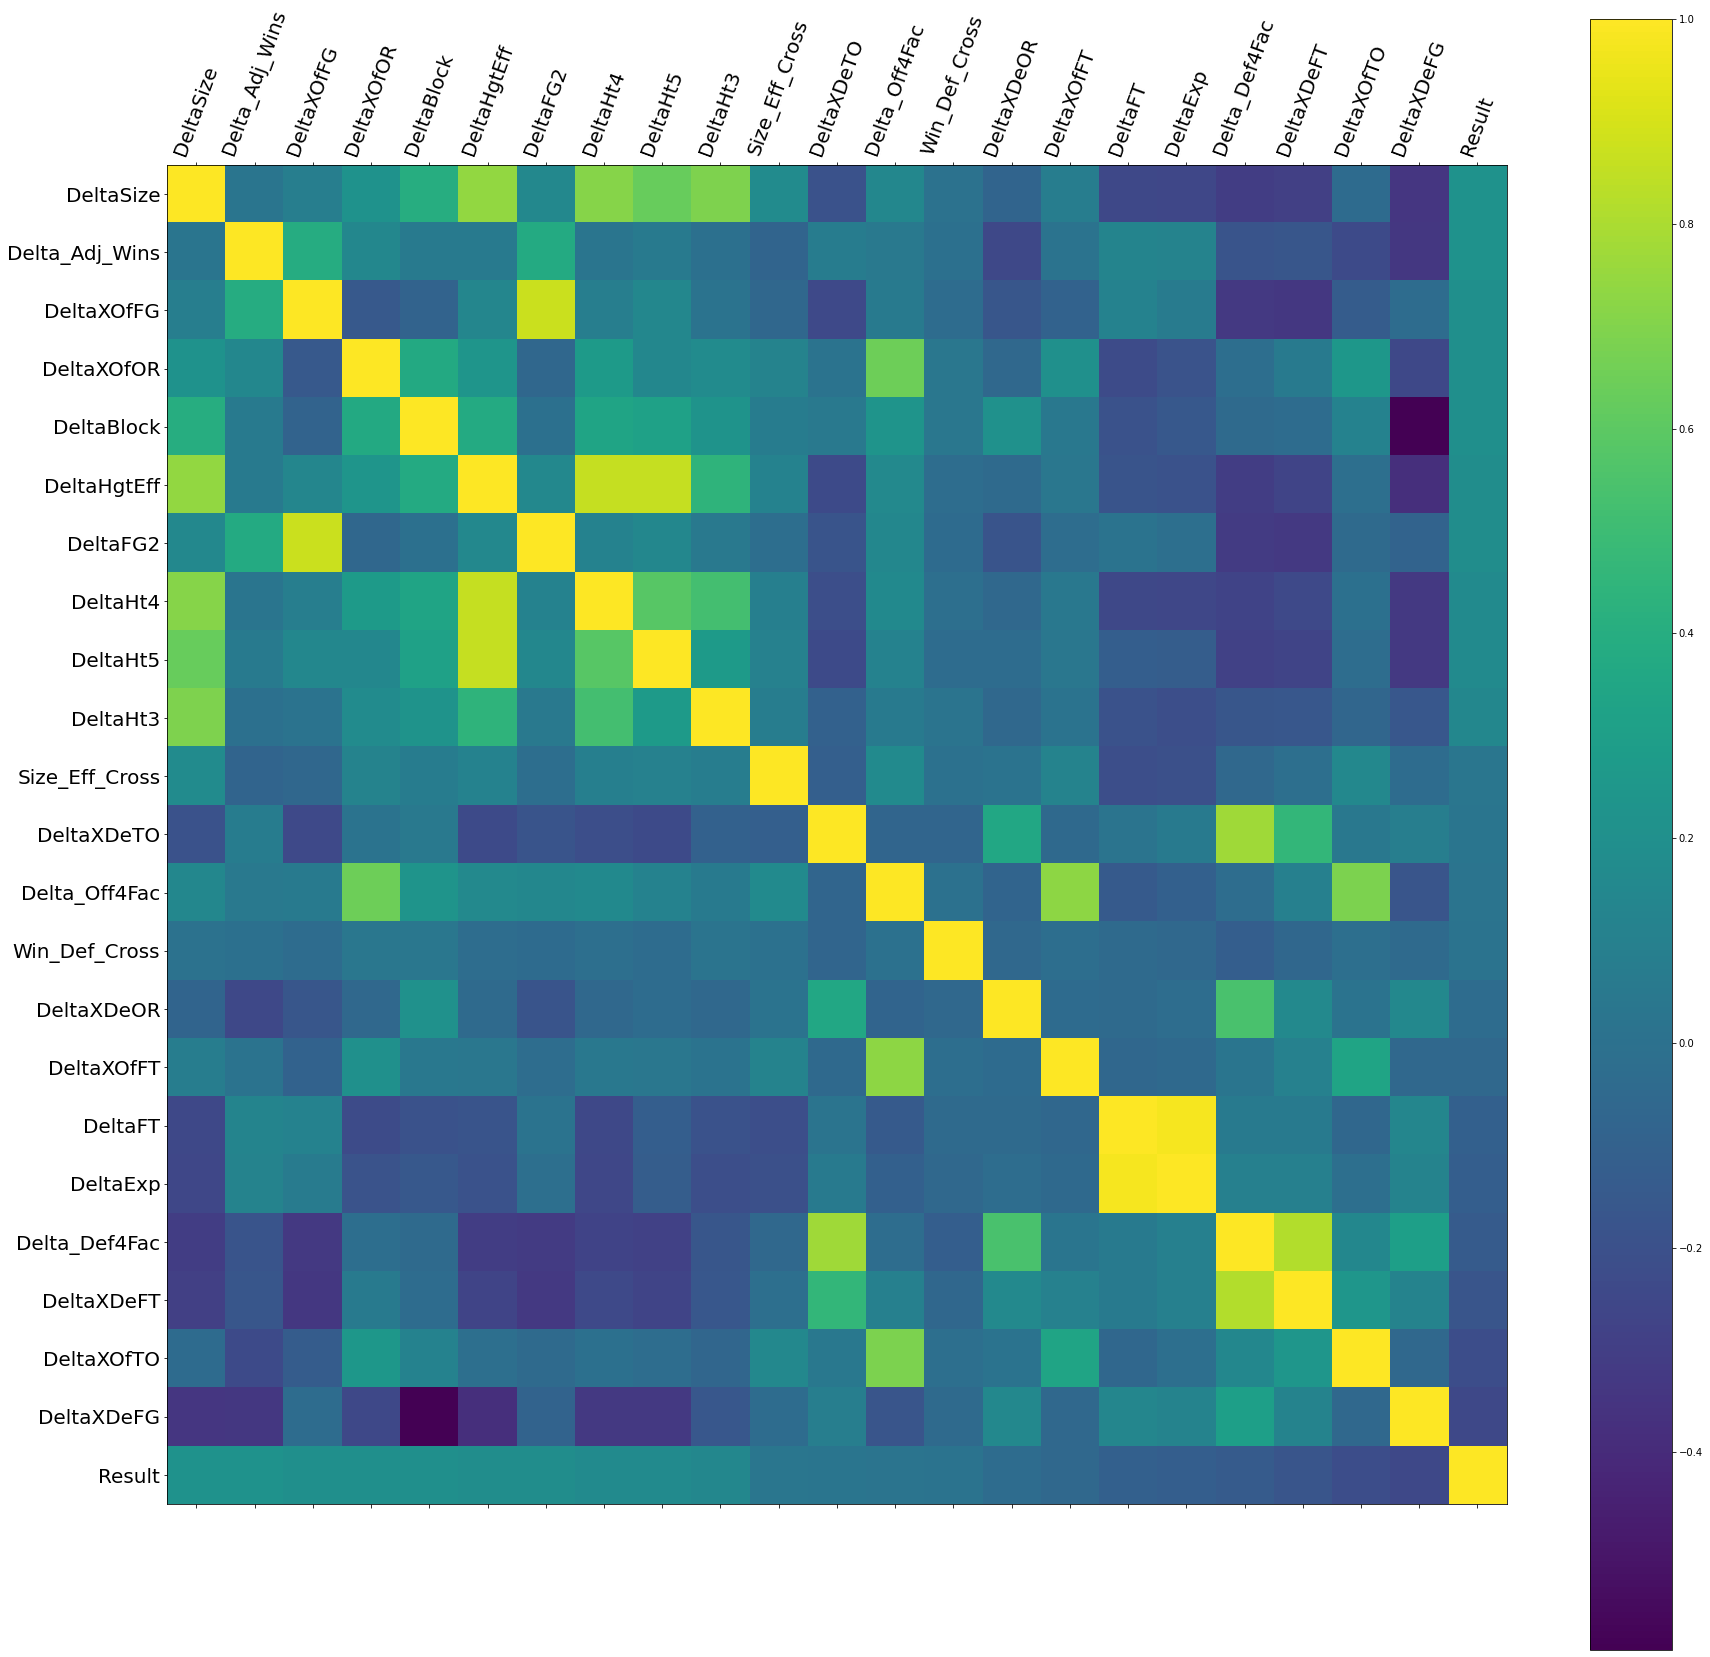

In [ ]:
def plot_corr(df, size=30):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=70)
    plt.yticks(range(len(corr.columns)), corr.columns)
    fig.colorbar(cax)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    fig.savefig('ncaa_corr_mat.png', bbox_inches='tight')
feat = features
feat.append('Result')
print(feat)
#df_c = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis=1)
df_c = training_set[feat]

# For hitters
df_c = df_c.drop_duplicates().dropna()
#df_scaled = df_c.apply(lambda x: preprocessing.MaxAbsScaler().fit_transform(x))
plot_corr(df_c)
#print( df_c.corr().sort_values('Result', ascending = False) )
training_set

## Define Neural Networks

This is done in Keras, but a good practice would be to migrate it to tf.keras for long term support.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.layers import BatchNormalization,Add,Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
from tensorflow.keras import optimizers


#optimizer = optimizers.SGD(learning_rate=0.1, nesterov=True)
optimizer = optimizers.Nadam(learning_rate=0.003)

# Simple residual network below that gives good results on NCAA dataset
def create_nn_model_res(input_shape, width, depth, dropout):
    inp = Input(shape=(input_shape,))
    x = Dense(width*2,  kernel_regularizer=regularizers.l2(0.005),
              kernel_initializer='lecun_normal')(inp)    
    x = LeakyReLU(alpha=0.05)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)

    for layer in range(depth):
        x = Dense(width,
                activity_regularizer=regularizers.l2(0.002))(x)  
        #x = Dense(width)(x)  
        x = LeakyReLU(alpha=0.05)(x)
        x_residual = x # Store the initial value of X in a variable
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        
        x = Dense(width*4)(inp)    
        x = LeakyReLU(alpha=0.05)(x)  
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)

        x = Dense(width)(inp)    
        x = LeakyReLU(alpha=0.05)(x)  
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)

        x = Dense(width*2)(inp)    
        x = LeakyReLU(alpha=0.05)(x)  
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        
        x = Dense(width)(x)    
        x = LeakyReLU(alpha=0.05)(x)   
        x = Add()([x, x_residual]) # SKIP Connection
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
    
    x = Dense(width)(x)    
    x = LeakyReLU(alpha=0.05)(x) 
    x = BatchNormalization()(x)
    x = Dropout(dropout/2)(x)
    
    x = Dense(width/2)(x)    
    x = LeakyReLU(alpha=0.05)(x) 
    x = BatchNormalization()(x)
    x = Dropout(dropout/2)(x)
        
    x = Dense(width/4)(x)    
    x = LeakyReLU(alpha=0.05)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout/2)(x)

    out = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.binary_accuracy, metrics.AUC()])
    return model

# Simpler Neural Network to compare to the residual network
def create_nn_model(input_shape, width, dropout):
    inp = Input(shape=(input_shape,))
    x = Dense(width, 
              kernel_regularizer=regularizers.l2(0.002),
              activity_regularizer=regularizers.l2(0.002), 
              kernel_initializer='lecun_normal')(inp)
    
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    
    x = Dense(width/5)(x)    
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(dropout/2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(width/10)(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(dropout/3)(x)
    x = BatchNormalization()(x)
    
    out = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.binary_accuracy, metrics.AUC()])
    return model


## Train the Neural Network

Below we have what we need to train the neural network and score results.

**************************************************************
Run executed with 400 and 0.6
**************************************************************
RANDOM SEEDS RESET
Epoch 1/200
26/26 [==============================] - 6s 48ms/step - loss: 1.6930 - binary_accuracy: 0.5569 - auc: 0.5761 - val_loss: 1.4960 - val_binary_accuracy: 0.5183 - val_auc: 0.6509 - lr: 0.0030
Epoch 2/200
26/26 [==============================] - 1s 19ms/step - loss: 1.4901 - binary_accuracy: 0.5920 - auc: 0.6292 - val_loss: 1.3936 - val_binary_accuracy: 0.5718 - val_auc: 0.6976 - lr: 0.0030
Epoch 3/200
26/26 [==============================] - 1s 23ms/step - loss: 1.3628 - binary_accuracy: 0.6392 - auc: 0.6908 - val_loss: 1.3372 - val_binary_accuracy: 0.5887 - val_auc: 0.7140 - lr: 0.0030
Epoch 4/200
26/26 [==============================] - 1s 21ms/step - loss: 1.3550 - binary_accuracy: 0.6065 - auc: 0.6516 - val_loss: 1.3196 - val_binary_accuracy: 0.5437 - val_auc: 0.7197 - lr: 0.0030
Epoch 5/200
26/26 [==

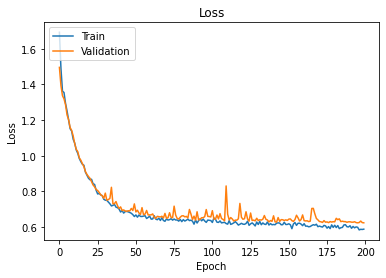

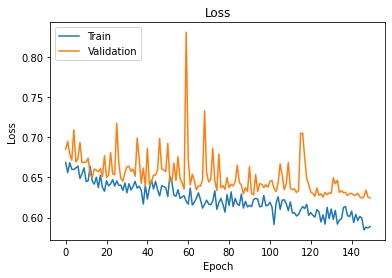

no adjustment


"df_out = pd.DataFrame()\ndf_out['width'] = w\ndf_out['dropout'] = d\ndf_out['results adj'] = resa\ndf_out['results non adj'] = resb\n"

In [ ]:
num_epochs = 200
batch_size = 32
verbose = True

retrain = True
depth = 2

def plot_history(history, start_val):
    plt.plot(history.history['loss'][start_val:])
    plt.plot(history.history['val_loss'][start_val:])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    if tf.__version__[0] == '2':
        tf.random.set_seed(3)
    else:
        tf.set_random_seed(3)
    print("RANDOM SEEDS RESET")
    


#weights_file = "/content/drive/'My Drive'/models/ncaa_model.h5"

model_dir = "/content/drive/'My Drive'/models"


def run_training_loop(width, dropout):
    
    weights_file = f"ncaa_model_{width}_{int(dropout*10)}.h5"
    sv_mod = callbacks.ModelCheckpoint(weights_file, monitor='val_loss', save_best_only=True, period=1)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,patience=15, min_lr=1e-6, mode='auto', verbose=1)
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.002, patience=90,verbose=1, baseline=.7, mode='auto', restore_best_weights=True)

    reset_seeds()
    if not retrain:
        model_nn = load_model(weights_file)
    else:
        #model_nn = create_nn_model_res(X_train.shape[1], width, depth, dropout)
        model_nn = create_nn_model(X_train.shape[1], width, dropout)
        #model_nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.binary_accuracy, metrics.AUC()])

    class_weights = dict(zip(np.unique(Y_train), class_weight.compute_class_weight(class_weight = 'balanced', 
                                                                                classes = np.unique(Y_train),
                                                                                y = Y_train)))  
 
    verbose_fit = 1
    history = model_nn.fit(X_train, Y_train, 
                           validation_data=(X_test, Y_test),  
                           epochs=num_epochs, 
                           shuffle=False, 
                           callbacks = [rlr, sv_mod],
                           batch_size=batch_size, 
                           class_weight = class_weights,
                           verbose=verbose_fit)
    
    model_inf = load_model(weights_file)
    
    pred = model_inf.predict(X_t)
    print(pred[0:20])

    plot_history(history, 0)
    plot_history(history, 50)

    '''if not stage2:
        df_score_adj, result_a = handle_submission(pred, test_set, 'Adjust')
        print('Adjusted Model log_loss: %6.3f' % result_a)
        df_score_na, result_na = handle_submission(pred, test_set, 'No Adjust')
        print('Unadjusted Model log_loss: %6.3f' % result_na)
        return df_score_adj, df_score_na

    else:'''
    handle_submission(pred, test_set, 'Adjust')
    handle_submission(pred, test_set, 'No Adjust')


    

    #del model_nn
    #K.clear_session()
    #tf.compat.v1.reset_default_graph()

    


resa, resb, w, d = [], [], [], []
#
# width = 400 and dropout = 0.6 seem to work well
# also, 1200/9 works well with wavelets on
#
for width in [400]:
    for dropout in [6]:
        dropout = dropout/10
        print('**************************************************************')
        print(f"Run executed with {width} and {dropout}")
        print('**************************************************************')

        run_training_loop(width, dropout)
        time.sleep(3)
        '''resa.append(result_a)
        resb.append(result_na)
        w.append(width)
        d.append(dropout)'''

'''df_out = pd.DataFrame()
df_out['width'] = w
df_out['dropout'] = d
df_out['results adj'] = resa
df_out['results non adj'] = resb
'''

## Accuracy Scoring

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

weights_file = f"ncaa_model_{width}_{int(dropout*10)}.h5"

model_inf = load_model(weights_file)
    
pred = model_inf.predict(X_t)

#df_score, result = handle_submission(pred, test_set, 'Adjust')
handle_submission(pred, test_set, 'Adjust')
print
#df_score_na = handle_submission(pred, test_set, 'No Adjust')

from sklearn.metrics import accuracy_score, classification_report
t_list = []
p = df_score['pred']
print(df_score.shape)
for idx,i in enumerate(p):
    t_list.append(np.round_(i))
        
df_score['pred2'] = t_list

df_score

print('accuracy: ', accuracy_score(df_score['true'], df_score['pred2']))
print(classification_report(df_score['true'], df_score['pred2']))


NameError: ignored